In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sys
sys.path.append('/workspace')

from Data import CallDataSet, dataset
from network import networks_target

import os
import medmnist
from medmnist import INFO

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


教師学習

In [3]:
#parameter
target_data = "MedMNIST"
data_flag = 'pneumoniamnist'
batch_size = 1000
#getting data_set
D_import = CallDataSet.DataLoad(target_data, batch_size, data_flag)
train_loader, test_loader = D_import.import_data()
#getting data_param
if 'data_flag' in globals():
    info = INFO[data_flag]
    n_channels = info['n_channels']
    n_classes = len(info['label'])

100%|██████████| 4170669/4170669 [00:01<00:00, 2316545.31it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 524
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1


tensor([1])


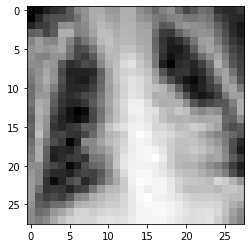

In [4]:
to_pil_image = transforms.ToPILImage()

for i, data in enumerate(train_loader):   
    pic = data[0]
    label = data[1]

    img_tensor = pic[0]

    img = to_pil_image(img_tensor)

    print(label[0])
    plt.imshow(img, cmap='gray')
    plt.show
    break

ディレクトリ作成

In [5]:
checkpoints_path = 'checkpoints_cloud/'
if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [6]:
base_dir = "/workspace/cloud_model/checkpoints_cloud"
new_dir = os.path.join(base_dir, target_data)
os.makedirs(new_dir, exist_ok=True)

モデル呼び出し

In [7]:
if target_data == "MedMNIST":
    teacher_net = networks_target.AttackerNetworkSmall_MNIST(n_classes)
else:
    teacher_net = networks_target.AttackerNetworkSmall_MNIST(10)
teacher_net = teacher_net.to('cuda')

学習フェーズ

In [8]:
#ターゲットモデル学習パラメータ
num_epochs =60
lr = 0.003
momentum = 0.5


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_net.parameters(), lr, weight_decay=0.0)
# 学習率減衰
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.5)
#list for saving learning_score
accuracy_list = [] 
loss_list = [] 

for epoch in range(num_epochs):
    for batch_id, dataset in enumerate(train_loader):
        data, label = dataset #cutting train data and label
        data, label = data.to('cuda'), label.to('cuda') #moving GPU device
        optimizer.zero_grad() #zero out the gradients for this batch
        outputs = teacher_net(data)
        if target_data == "MedMNIST":
            label = label.squeeze().long()
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
    if epoch % 3 == 0:
        acc = torch.sum(torch.argmax(outputs,dim =1) == label).item()/label.shape[0]
        accuracy_list.append(acc)
        loss_list.append(loss)
        print('epoch: %d validation loss: %.3f validation accuracy: %.3f' %(epoch, loss, acc))
    lr_scheduler.step()
    



epoch: 0 validation loss: 0.617 validation accuracy: 0.733
epoch: 3 validation loss: 0.520 validation accuracy: 0.739
epoch: 6 validation loss: 0.427 validation accuracy: 0.787
epoch: 9 validation loss: 0.302 validation accuracy: 0.894
epoch: 12 validation loss: 0.245 validation accuracy: 0.915
epoch: 15 validation loss: 0.274 validation accuracy: 0.884
epoch: 18 validation loss: 0.222 validation accuracy: 0.911
epoch: 21 validation loss: 0.231 validation accuracy: 0.912
epoch: 24 validation loss: 0.223 validation accuracy: 0.911
epoch: 27 validation loss: 0.207 validation accuracy: 0.919
epoch: 30 validation loss: 0.203 validation accuracy: 0.922
epoch: 33 validation loss: 0.214 validation accuracy: 0.917
epoch: 36 validation loss: 0.191 validation accuracy: 0.915
epoch: 39 validation loss: 0.232 validation accuracy: 0.894
epoch: 42 validation loss: 0.204 validation accuracy: 0.929
epoch: 45 validation loss: 0.187 validation accuracy: 0.931
epoch: 48 validation loss: 0.217 validation 

In [9]:
def calculate_accuracy(model, dataloader):
    model.to('cuda')
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            if target_data == "MedMNIST":
                labels = labels.squeeze().long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

In [10]:
# Getting accuracy
accuracy = calculate_accuracy(teacher_net, test_loader)
print(accuracy)

91.79389312977099


In [11]:
correct=0
total=0

with torch.no_grad():
   for (images, labels) in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda') 
        labels=torch.reshape(labels,(-1,)) #1次元に変更
        outputs = teacher_net(images) #テストに対するforwardを実行
        _, predicted = torch.max(outputs.data, 1) #axis=1, _は確率の最大値,predictedは最大値のインデックス
        total += labels.size()[0] #例:(100,28,28)が画像のサイズ、.size[0]で100を返す
        correct += (predicted == labels).sum().item() #論理演算でtensor([ True, False,  True,…])にし、.sumでTrue=1,False=0で合計をtensor(sum)にし,.itemでsumを取り出す
print('Accuracy: {:.2f} %%'.format(100 * float(correct/total)))

Accuracy: 91.79 %%


In [12]:
# モデル保存
teacher_net = teacher_net.to('cpu')
# モデル名取得
class_name = teacher_net.__class__.__name__
file_name = f"!{class_name}_epoch_{num_epochs}_data_{target_data}"
save_path = os.path.join(new_dir, file_name)
torch.save({'results' : accuracy, 
            'model_state_dict' : teacher_net.state_dict(), 
            'epoch' : num_epochs}, save_path)

=================================

In [12]:
import matplotlib.pyplot as plt
import torch

from pathlib import Path

In [33]:
model_size = ["Fashion","Frac1k","Frac60","MNIST"]
model_paths = []
for size in model_size:
    path = Path("/workspace/attacker_train/checkpoints_student/FashionMNIST")
    minipath = "size_M_query_57_Batch_1000_FashionMNIST"
    fullpath = path/size/minipath
    print(fullpath)
    model_paths.append(fullpath)

/workspace/attacker_train/checkpoints_student/MNIST/Fashion/size_M_query_57_Batch_1000_MNIST
/workspace/attacker_train/checkpoints_student/MNIST/Frac1k/size_M_query_57_Batch_1000_MNIST
/workspace/attacker_train/checkpoints_student/MNIST/Frac60/size_M_query_57_Batch_1000_MNIST
/workspace/attacker_train/checkpoints_student/MNIST/MNIST/size_M_query_57_Batch_1000_MNIST


In [39]:
model_paths[2] = '/workspace/attacker_train/checkpoints_student/MNIST/Frac1k/size_M_query_70_Frac1k_MNIST'

In [40]:
model_paths[3] = '/workspace/attacker_train/checkpoints_student/MNIST/Frac60/size_M_query_70_Frac60_MNIST'

In [44]:
def load_model_results(path_list):
    results = []
    for path in path_list:
        checkpoint = torch.load(path)
        results.append(checkpoint['results'])
    return results

In [45]:
results = load_model_results(model_paths)

for i, result in enumerate(results):

    print(f"Results for model {i+1}: {result}")

Results for model 1: [56.269999999999996, 73.98, 82.52000000000001, 88.19, 91.56, 93.36, 95.7, 96.61, 97.22, 97.46000000000001, 97.65, 97.74000000000001, 97.83, 97.85000000000001, 97.92999999999999, 97.95, 97.95, 98.02, 98.02, 98.05, 97.97, 98.08, 98.06, 98.02, 98.06, 98.04, 98.06, 98.08, 98.09, 98.06, 98.06, 98.11999999999999, 98.03, 98.07000000000001, 98.08, 98.07000000000001, 98.07000000000001, 98.06, 98.08, 98.06, 98.06, 98.06, 98.05, 98.08, 98.08, 98.1, 98.09, 98.08, 98.08, 98.11]
Results for model 2: [52.480000000000004, 83.8, 93.71000000000001, 95.97, 97.37, 97.55, 97.57000000000001, 97.88, 97.92999999999999, 97.95, 98.04, 97.91, 98.09, 98.1, 98.07000000000001, 98.06, 98.05, 98.06, 98.08, 98.11, 98.09, 98.09, 98.08, 98.08, 98.07000000000001, 98.09, 98.11, 98.09, 98.11, 98.1, 98.08, 98.05, 98.08, 98.09, 98.11, 98.07000000000001, 98.08, 98.1, 98.11999999999999, 98.09, 98.09, 98.07000000000001, 98.07000000000001, 98.09, 98.07000000000001, 98.09, 98.09, 98.07000000000001, 98.1199999

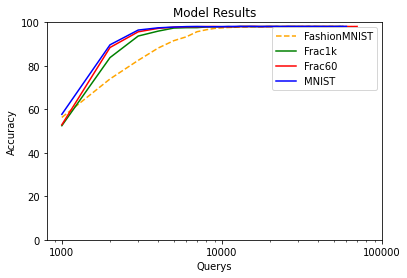

In [46]:
import numpy as np

# 対数軸に設定
plt.xscale("log")
# x軸の値を作成します。
x_values = [i for i in range(1, max(len(results[0]), len(results[1]), len(results[2]), len(results[3])) + 1)]


plt.plot(x_values[:len(results[0])], results[0], color = 'orange', label="FashionMNIST", linestyle='--')
plt.plot(x_values[:len(results[1])], results[1], color = 'green', label=model_size[1])
plt.plot(x_values[:len(results[2])], results[2], color = 'red', label=model_size[2])
plt.plot(x_values[:len(results[3])], results[3], color = 'blue', label=model_size[3])

# グラフにタイトルを設定します。
plt.title('Model Results')

# x軸とy軸にラベルを設定します。
plt.xlabel('Querys')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.gca().set_xticks([1, 10, 100])

# x軸の目盛りのラベルを指定します。10の3乗から始まり、10のスケールで増えるように設定します。
plt.gca().set_xticklabels([10**3, 10**4, 10**5])

plt.legend()
plt.show()
